## Instalando e Carregando Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.15


In [2]:
# Instala o TensorFlow
# !pip install -q tensorflow==2.5

In [3]:
# Instala o Pydot, Pydotplus e Graphviz
# !pip install pydot
# !pip install graphviz
# !pip install pydotplus
import pydot
import pydotplus
import graphviz

In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
print(tf.__version__)

2.11.0


## Carregando os Dados

### Boston House Prices Dataset

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

#### Características:

* Número de Observções: 506
* Os primeiros 13 recursos são recursos preditivos numéricos / categóricos. 
* O último (atributo 14): o valor mediano é a variável de destino.

In [7]:
# Download dos dados
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
dataset_path = tf.keras.utils.get_file("housing.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

In [8]:
# Nomes das colunas
nomes_colunas = ['CRIM',
                 'ZN',
                 'INDUS',
                 'CHAS',
                 'NOX',
                 'RM', 
                 'AGE', 
                 'DIS',
                 'RAD',
                 'TAX',
                 'PTRATION', 
                 'B', 
                 'LSTAT', 
                 'MEDV']

In [9]:
# Carrega os dados
dataset = pd.read_csv(dataset_path, 
                      names = nomes_colunas,
                      na_values = "?", 
                      comment = '\t',
                      sep = " ", 
                      skipinitialspace = True)

In [10]:
# Shape
dataset.shape

(506, 14)

In [11]:
# Visualiza os dados
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATION,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Vamos dividir os dados em treino e teste com proporção 80/20.

In [22]:
# Split dos dados
dados_treino = dataset.sample(frac = 0.8, random_state = 0)
dados_teste = dataset.drop(dados_treino.index)

## Modelagem Preditiva - Regressão Linear Simples

Na regressão linear simples desejamos modelar a relação entre a variável dependente (y) e uma variável independente (x).

* Variável independente: 'RM'
* Variável dependente: 'MEDV'

Queremos prever o valor da mediana das casas ocupadas por proprietários com base no número de quartos.

Vamos criar um plot mostrando a relação atual entre as variáveis.

Basicamente temos $MEDV=f(RM)$ e queremos estimar a função $f()$ usando regressão linear.

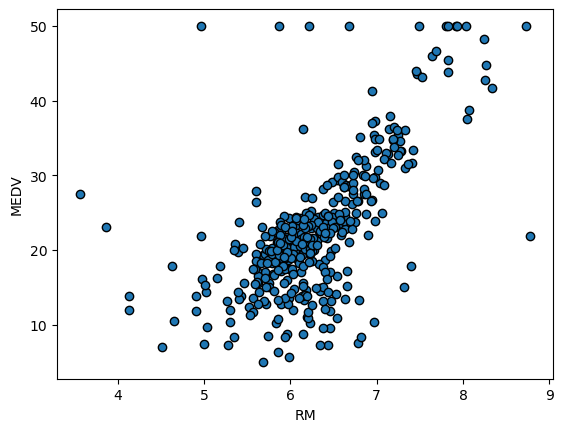

In [23]:
# Representação visual dos dados de treino
fig, ax = plt.subplots()
x = dados_treino['RM']
y = dados_treino['MEDV']
ax.scatter(x, y, edgecolors = (0, 0, 0))
ax.set_xlabel('RM')
ax.set_ylabel('MEDV')
plt.show()

Vamos separar x e y.

In [24]:
# Divisão
x_treino = dados_treino['RM']
y_treino = dados_treino['MEDV']
x_teste = dados_teste['RM']
y_teste = dados_teste['MEDV']

## Criação do Modelo

Queremos encontrar os parâmetros (**W**) que permitem prever a saída y a partir da entrada x:

$y = w_1 x + w_0$

A fórmula acima pode ser definida com a seguinte camada densa em um modelo de rede neural artificial:

*layers.Dense(1, use_bias=True, input_shape=(1,))*

In [25]:
# Função para construir o modelo
def modelo_linear():
    
    # Cria o modelo
    model = tf.keras.Sequential([layers.Dense(1, use_bias = True, input_shape = (1,), name = 'layer')])

    # Otimizador
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, 
                                         beta_1 = 0.9, 
                                         beta_2 = 0.99, 
                                         epsilon = 1e-05, 
                                         amsgrad = False, 
                                         name = 'Adam')
    
    # Compila o modelo
    model.compile(loss = 'mse', 
                  optimizer = optimizer, 
                  metrics = ['mae','mse'])

    return model

MAE = Mean Absolute Error

MSE = Mean Squared Error

In [26]:
# Cria o modelo 
modelo = modelo_linear()

In [27]:
# Plot do modelo
tf.keras.utils.plot_model(modelo, 
                          to_file = 'C:/Users/jllce/Documents/JLLC/Estudos/Python Fundamentos - DSAcademy/Cap10/Notebooks/imagens/modelo.png', 
                          show_shapes = True, 
                          show_layer_names = True,
                          rankdir = 'TB', 
                          expand_nested = False, 
                          dpi = 100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Treinamento do Modelo

In [28]:
# Hiperparâmetros
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save = n_epochs_log * x_treino.shape[0]
print('Checkpoint salvo a cada {} amostras'.format(n_samples_save))

Checkpoint salvo a cada 81000 amostras


In [29]:
# Callback (é uma técnica para o modelo nao aprender demais - evitar overfitting)
# Ou seja, com o EarlyStopping eu consigo falar pro modelo ir rodando até X épocas. Mas se ele começar a não
# aprender mais nada por um certo período de tempo, eu peço pra ele parar.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                 patience = n_idle_epochs, 
                                                 min_delta = 0.001)

In [30]:
# Lista para as previsões
predictions_list = []

In [49]:
# Caminho ppara salvar o checkpoint
checkpoint_path = "C:/Users/jllce/Documents/JLLC/Estudos/Python Fundamentos - DSAcademy/Cap10/Notebooks/dados"

In [50]:
# Create a callback that saves the model's weights every n_samples_save
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                                        verbose = 1, 
                                                        save_weights_only = True,
                                                        save_freq = n_samples_save)

In [51]:
# Salva a primeira versão do modelo
modelo.save_weights(checkpoint_path.format(epoch = 0))

In [52]:
# Treinamento
history = modelo.fit(x_treino, 
                     y_treino, 
                     batch_size = batch_size,
                     epochs = n_epochs, 
                     validation_split = 0.1, 
                     verbose = 1, 
                     callbacks = [earlyStopping, checkpointCallback])

Epoch 1/4000
2/2 [==============================] - 2s 332ms/step - loss: 355.8362 - mae: 16.9193 - mse: 355.8362 - val_loss: 431.6270 - val_mae: 18.1612 - val_mse: 431.6270
Epoch 2/4000
2/2 [==============================] - 0s 61ms/step - loss: 350.8480 - mae: 16.7742 - mse: 350.8480 - val_loss: 426.2388 - val_mae: 18.0155 - val_mse: 426.2388
Epoch 3/4000
2/2 [==============================] - 0s 68ms/step - loss: 345.7832 - mae: 16.6300 - mse: 345.7832 - val_loss: 420.8993 - val_mae: 17.8698 - val_mse: 420.8993
Epoch 4/4000
2/2 [==============================] - 0s 70ms/step - loss: 340.8661 - mae: 16.4858 - mse: 340.8661 - val_loss: 415.6028 - val_mae: 17.7242 - val_mse: 415.6028
Epoch 5/4000
2/2 [==============================] - 0s 52ms/step - loss: 336.0037 - mae: 16.3422 - mse: 336.0037 - val_loss: 410.3581 - val_mae: 17.5788 - val_mse: 410.3581
Epoch 6/4000
2/2 [==============================] - 0s 62ms/step - loss: 331.2174 - mae: 16.1994 - mse: 331.2174 - val_loss: 405.1770 

In [53]:
# Métricas do histórico de treinamento
print('keys:', history.history.keys())

keys: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


MSE = Mean Squared Error

In [54]:
# Retornando os valores desejados para o plot (mse, métrica do erro do modelo em treino e o
# val_mse, métrica do erro do modelo em validação)
mse = np.asarray(history.history['mse'])
val_mse = np.asarray(history.history['val_mse'])

In [55]:
# Prepara os valores para o dataframe
num_values = (len(mse))
values = np.zeros((num_values, 2), dtype = float)
values[:,0] = mse
values[:,1] = val_mse

In [56]:
# Cria o dataframe
steps = pd.RangeIndex(start = 0, stop = num_values)
df = pd.DataFrame(values, steps, columns = ["MSE em Treino", "MSE em Validação"])

In [59]:
df.head()

,MSE em Treino,MSE em Validação
0,355.836243,431.627014
1,350.847961,426.238770
2,345.783173,420.899292
3,340.866058,415.602753
4,336.003662,410.358124


<AxesSubplot:>

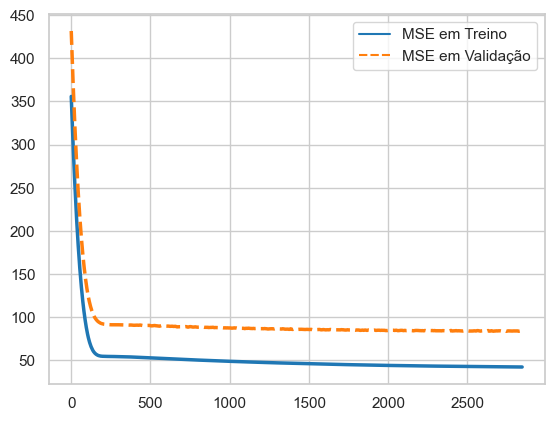

In [60]:
# Plot
sns.set(style = "whitegrid")
sns.lineplot(data = df, palette = "tab10", linewidth  = 2.5)

In [61]:
# Previsões com o modelo treinado
previsoes = modelo.predict(x_teste).flatten()

4/4 [==============================] - 0s 2ms/step


In [62]:
# Imprime as previsões
previsoes

array([20.574097, 17.810532, 23.924492, 21.038101, 20.20562 , 20.3148  ,
       24.606853, 21.699993, 20.75151 , 20.533154, 26.114872, 23.39225 ,
       20.990337, 22.607533, 23.201187, 21.37246 , 27.418182, 23.310368,
       30.209042, 19.530083, 20.0555  , 20.690098, 18.711246, 20.574097,
       18.45195 , 23.487782, 22.771301, 13.218239, 16.479923, 36.75289 ,
       21.235985, 17.626293, 19.584675, 22.69624 , 32.590485, 24.3885  ,
       21.590813, 28.585022, 26.005695, 33.341084, 28.100544, 31.532825,
       33.190964, 16.479923, 22.989655, 23.228485, 17.769588, 23.535545,
       38.997864, 36.909832, 17.54441 , 36.22065 , 32.085537, 26.18311 ,
       23.637901, 22.69624 , 26.421936, 28.38031 , 24.84568 , 24.41579 ,
       23.11248 , 18.554306, 23.378601, 22.703064, 20.799278, 19.830322,
       20.949394, 21.993408, 21.413399, 21.311047, 27.479595, 24.97533 ,
        9.41066 , 12.90435 , 16.384396, 23.310368, 16.814285, 17.346527,
       23.351307, 21.249634, 19.837143, 26.230877, 